# Investigating the correlation between plant pairs (related by genus) and the phytochemicals present in them

### Import modules

In [1]:
import logging
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import obonet
import networkx as nx

# Phylogenetics
from ete3 import NCBITaxa

# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
logger = logging.getLogger('__name__')

In [3]:
%matplotlib inline

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
DATA_DIR = '../data/processed'
MAPPING_DIR = '../data/mapping'

### Load plant-disease evidences

In [6]:
plant_disease_df = pd.read_csv(
    f'{DATA_DIR}/plant_disease_collapsed.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'disease_curie',
        'database'
    ],
    low_memory=False
)
plant_disease_df

,plant_curie,disease_curie,database
0,ncbitaxon:3369,mondo:0024623,bern2
1,ncbitaxon:3369,mondo:0005087,bern2
2,ncbitaxon:3369,mondo:0021166,bern2
3,ncbitaxon:3369,mondo:0005046,bern2
4,ncbitaxon:3369,mondo:0024623,bern2
...,...,...,...
172697,ncbitaxon:99809,mondo:0003900,koreantk
172698,ncbitaxon:99809,mondo:0005066,koreantk
172699,ncbitaxon:99809,mondo:0002081,koreantk
172700,ncbitaxon:99809,mondo:0005046,koreantk


In [7]:
medicinal_plants = plant_disease_df['plant_curie'].unique().tolist()

len(medicinal_plants)

5636

### Load plant-chemcial data

In [8]:
plant_chemical_df = pd.read_csv(
    f'{DATA_DIR}/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'plant name',
        'chemical_curie',
        'evidence'
    ],
    low_memory=False
)

plant_chemical_df.rename(columns={'plant name': 'plant_name'}, inplace=True)

plant_chemical_df.head(1)

,plant_curie,plant_name,chemical_curie,evidence
0,ncbitaxon:1000425,Pimpinella major,pubchem.compound:3527,Relation from COCONUT


### Subset chemicals to medicinal plants only

In [9]:
plant_chemical_df = plant_chemical_df[plant_chemical_df['plant_curie'].isin(medicinal_plants)]

In [10]:
plant_chemical_df.shape

(154933, 4)

### Add genus information for plants

In [11]:
ncbi = NCBITaxa()

In [12]:
lineage_dict = defaultdict(list)
p_names = defaultdict(str)

for plant in tqdm(medicinal_plants):
    tree = ncbi.get_lineage(plant.split(':')[1])
    plant_name = ncbi.get_taxid_translator([plant.split(':')[1]])
    plant_name = {
        f'ncbitaxon:{i}': j
        for i, j in plant_name.items()
    }
    
    p_names.update(plant_name)
    
    tree = [
        f'ncbitaxon:{i}'
        for i in tree
    ]
    
    lineage_dict[plant] = tree

  0%|                                                                                                                                              | 0/5636 [00:00<?, ?it/s]/Users/yojana/anaconda3/envs/kg-sources/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 32224 was translated into 2843217
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/yojana/anaconda3/envs/kg-sources/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 48038 was translated into 2849586
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
  9%|███████████▉                                                                                                                      | 519/5636 [00:00<00:00, 5187.30it/s]/Users/yojana/anaconda3/envs/kg-sources/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 23810 was translated into 2768810
  warnings

In [13]:
plant_chemical_df['parent'] = plant_chemical_df['plant_curie'].map(lineage_dict)

Split the dataframe such that there is one plant-parent pair each row

In [14]:
plant_chemical_df = plant_chemical_df.explode(['parent'])

In [15]:
plant_chemical_df.head(2)

,plant_curie,plant_name,chemical_curie,evidence,parent
49,ncbitaxon:100136,Leptolobium panamense,pubchem.compound:73806653,Relation from COCONUT,ncbitaxon:1
49,ncbitaxon:100136,Leptolobium panamense,pubchem.compound:73806653,Relation from COCONUT,ncbitaxon:131567


### Usecase functions

In [16]:
def get_subset(parent_curie: str):
    """Get genus specific subset from the plant-disease and plant-chemical data."""
    chem_df = plant_chemical_df[plant_chemical_df['parent'] == parent_curie.lower()]
    
    logger.warning(f'No.of plants in the genus - {len(chem_df.plant_curie.unique())}')
    logger.warning(f'No.of chemicals the genus contains - {len(chem_df.chemical_curie.unique())}')
    return chem_df

In [17]:
def create_chemical_matrix(df: pd.DataFrame):
    """Create a plant vs chemicals binary vector matrix"""
    
    dist_matrix = pd.DataFrame(
        columns=df['chemical_curie'].unique(), index=df['plant_name'].unique()
    )
    dist_matrix.fillna(0, inplace=True)
    
    for row in tqdm(df.values):
        (
            plant_curie,
            plant_name,
            chemical_curie,
            source,
            plant_family,
        ) = row

        dist_matrix.loc[plant_name, chemical_curie] = 1
    
    # Keeping columns that occur in more than 1 plant
    cols_to_remove = []
    for col in dist_matrix.columns:
        val_counts = dist_matrix[col].value_counts().to_dict()
        if val_counts[1] < 5:
            cols_to_remove.append(col)
            
    dist_matrix.drop(columns=cols_to_remove, inplace=True)
    
    return dist_matrix

In [18]:
def create_cluster(dist_df: pd.DataFrame, plants_of_interest: list, plant_name: str, figure_num: str):
    """Generating a clustermap for the data."""
    
    cmap = ListedColormap(['#f1e4e4', '#a12d2d'])
        
    g = sns.clustermap(
        dist_df, 
        cmap=cmap,
        fmt='g', 
        vmin=0,
        vmax=1, 
        yticklabels=dist_df.index, 
        xticklabels=True, 
        linecolor='white', 
        col_cluster=False,
        cbar_pos=None,
    )
    
    for tick_label in g.ax_heatmap.yaxis.get_majorticklabels():
        name = tick_label.get_text()
        if name in plants_of_interest:
            tick_label.set_weight('bold')
        else:
            tick_label.set_weight('normal')
    
    g.ax_heatmap.set_title(
        f'Clustering the $\it{plant_name}$ genus by their chemical composition',
        fontsize=18,
        y=1.05,
    )
    
    plt.tight_layout()
    plt.savefig(
        f'../data/figures/supplementary_figure_{figure_num}_clustering.png',
        dpi=400,
        bbox_inches='tight', 
    )
    
    return plt.show()


### Usecase 1: Salvia genus (NCBITaxon:21880)

In [19]:
example1_chem_df = get_subset('ncbitaxon:21880')
example1_chem_df.shape

No.of plants in the genus - 21
No.of chemicals the genus contains - 1073


(1530, 5)

Creating distance matrix for the subset

In [20]:
example_1_chemical_matrix = create_chemical_matrix(example1_chem_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:00<00:00, 8906.80it/s]


Get clustermap for usecase

In [21]:
## All plants having the chemical Reserpine
plants_of_interest = [
    'Salvia officinalis',
    'Salvia rosmarinus',
    'Salvia miltiorrhiza'
]

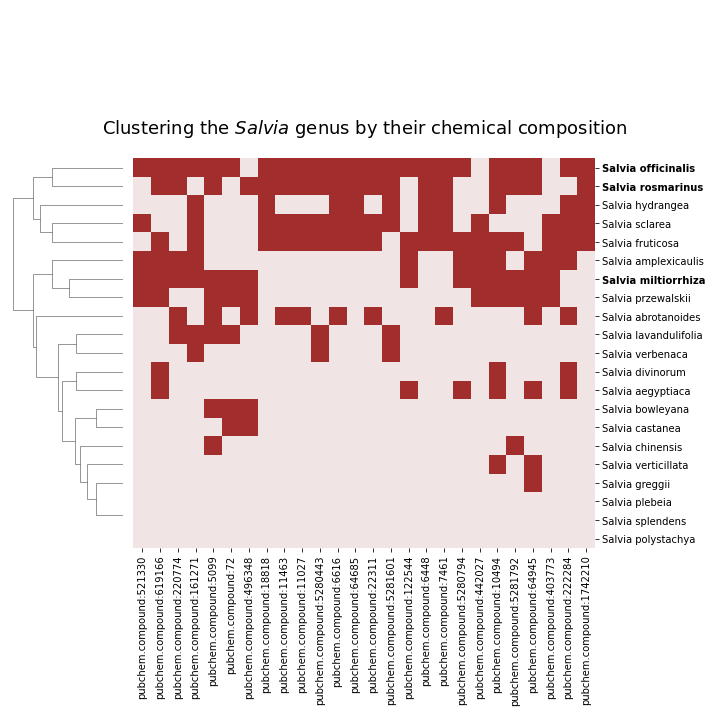

In [22]:
create_cluster(example_1_chemical_matrix, plants_of_interest, 'Salvia', '7_A')

### Usecase 2: Angelica genus (NCBITaxon:40948)

In [23]:
example2_chem_df = get_subset('ncbitaxon:40948')
example2_chem_df.shape

No.of plants in the genus - 11
No.of chemicals the genus contains - 775


(1435, 5)

Creating distance matrix for the subset

In [24]:
example_2_chemical_matrix = create_chemical_matrix(example2_chem_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1435/1435 [00:00<00:00, 9979.48it/s]


Get clustermap for usecase

In [25]:
## All plants having the chemical Reserpine
plants_of_interest = [
    'Angelica gigas', 
    'Angelica sinensis'
]

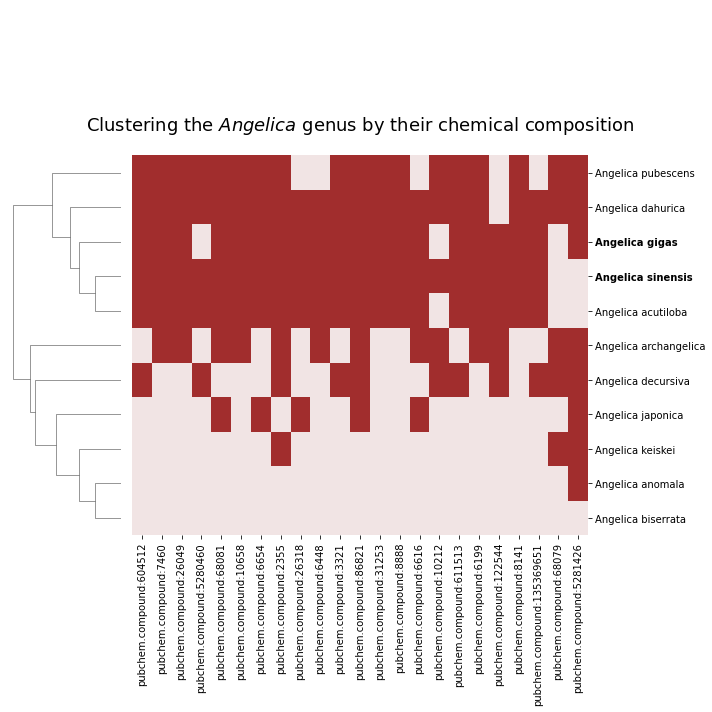

In [26]:
create_cluster(example_2_chemical_matrix, plants_of_interest, 'Angelica', '7_C')